# Profit Prediction using Machine Learning
This notebook aims to predict profit from product and sales-related features using regression models. Models used include XGBoost, SVR, Ridge, and Lasso. Feature engineering, model tuning, and evaluation are performed.


Since we are predicting profit,we use regression models most of which requires encoding of data.
So we use one hot encoding for columns with low cardinality(less number of unique values),
and frequency encoding for columns with high cardinality(more numbe rof unique values).


In [1]:
from utils import *
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


In [2]:
#To ensure the model is not very random in each iteration
import random, numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
df=pd.read_csv("E:\Backup\Data\Processed&FeatureEngineered.csv")

<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Admin\AppData\Local\Temp\ipykernel_26736\454961572.py:1: SyntaxWarning: invalid escape sequence '\B'
  df=pd.read_csv("E:\Backup\Data\Processed&FeatureEngineered.csv")


**Dataset Overview**

While we cannot display the data, the dataset contains features such as:
- Product-related features (category, type, pattern, color)
- Sales metrics (unit sale value, discount, quantity sold)
- Temporal data (season, month)
Target variable: `PROFIT`


In [4]:
df.columns

Index(['Unnamed: 0', 'ITEMNAME', 'PATTERN', 'COLOR', 'SUPPCITY', 'MONTH',
       'NETSALESRATE', 'PROFITPER', 'SALESQTY', 'SALESAMOUNT',
       'UNIT_SALE_VALUE', 'PROFIT', 'IS_DISCOUNTED', 'ITEM_FREQ',
       'LOG_PROFIT'],
      dtype='object')

In [5]:
leaky_cols = ['PROFITPER', 'PROFIT'] 
df = df.drop(columns=leaky_cols, errors='ignore')


* The columns 'PROFIT' and 'PROFITPER' are dropped as they are directly represented by 'LOG_PROFIT' and similar derived features. 
* Including them would introduce data leakage and redundancy without improving model performance.

In [6]:
categorical_cols=df.select_dtypes(exclude=['int64','float64']).columns
print(categorical_cols)

Index(['ITEMNAME', 'PATTERN', 'COLOR', 'SUPPCITY', 'IS_DISCOUNTED'], dtype='object')


In [7]:
df[categorical_cols].nunique()


ITEMNAME         115
PATTERN          658
COLOR             55
SUPPCITY          33
IS_DISCOUNTED      2
dtype: int64

**ENCODING**

I used One-Hot Encoding for low-cardinality features to avoid implying any order between categories, and Frequency Encoding for high-cardinality features to reduce dimensionality and keep the model efficient.

In [8]:

#Frequency Encoding for high-cardinality features
frequency_encoding = df['ITEMNAME'].value_counts()
df['ITEM_FREQ'] = df['ITEMNAME'].map(frequency_encoding)
df['PATTERN'] = df['PATTERN'].map(df['PATTERN'].value_counts())
df_clean= df.drop(columns=['ITEMNAME'])


* We split before encoding to prevent data leakage.

* Data leakage happens when information from the test set influences the model during training, leading to over-optimistic performance.

* If we encoded the whole dataset before splitting, the encoder would "see" all categories (including those only present in the test set) and their statistics, giving the model unfair knowledge.

* This keeps our evaluation realistic and avoids accidental cheating.

In [9]:
x=df_clean.drop(['LOG_PROFIT'],axis=1)
y=df_clean['LOG_PROFIT']

x['UNIT_SALE_VALUE'] = x['UNIT_SALE_VALUE'].replace([np.inf, -np.inf], np.nan)
x['UNIT_SALE_VALUE']= x['UNIT_SALE_VALUE'].fillna(x['UNIT_SALE_VALUE'].mean(numeric_only=True))

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.4,random_state=42)

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore') 
low_cardinality_cat_columns=['SUPPCITY', 'COLOR',  'IS_DISCOUNTED']
X_train_encoded = encoder.fit_transform(x_train[low_cardinality_cat_columns])  # Learn categories from training set
X_test_encoded = encoder.transform(x_test[low_cardinality_cat_columns]) 


In [10]:
# Separate numeric columns
numeric_cols = [col for col in x_train.columns if col not in low_cardinality_cat_columns]

# Get categorical feature names after encoding
cat_feature_names = encoder.get_feature_names_out(low_cardinality_cat_columns)

# Combine numeric + encoded categorical columns
X_train_encoded = np.hstack([x_train[numeric_cols].to_numpy(), X_train_encoded])
X_test_encoded= np.hstack([x_test[numeric_cols].to_numpy(), X_test_encoded])

# Combine feature names for all columns
encoded_feature_names = numeric_cols + cat_feature_names.tolist()



Now lets train a model where we predict the profit  for a new product based on its pattern, color, supplier city, and expected sales quantity

In [11]:
import time

models = {
    'Linear_regression': LinearRegression(),
    'Lasso_regression': Lasso(),
    'Ridge_regression': Ridge(),
    'SVR': SVR(kernel='rbf'),
    'Xgboost Regressor': XGBRegressor(random_state=42)
}



# Model training & evaluation
start = time.time()

def evaluate_model(name, model, X_test_encoded, y_test):
    y_pred = model.predict(X_test_encoded)
    print('\n')
    print(f"{name}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")

for name, model in models.items():
    print('-' * 90)
    model.fit(X_train_encoded, y_train)
    prediction = model.predict(X_test_encoded)

    evaluate_model(name,model,X_test_encoded,y_test)

end = time.time()
print(f"Training Time: {end - start:.2f} seconds")


------------------------------------------------------------------------------------------


Linear_regression
R²: 0.1572
RMSE: 1.3788
MAE: 0.7952
------------------------------------------------------------------------------------------


Lasso_regression
R²: 0.0878
RMSE: 1.4344
MAE: 0.8278
------------------------------------------------------------------------------------------


Ridge_regression
R²: 0.1644
RMSE: 1.3728
MAE: 0.7934
------------------------------------------------------------------------------------------


SVR
R²: 0.2192
RMSE: 1.3271
MAE: 0.6450
------------------------------------------------------------------------------------------


Xgboost Regressor
R²: 0.5496
RMSE: 1.0079
MAE: 0.5176
Training Time: 1.53 seconds


The accuracy of all the models are quite low,and the highest itself is only 50.
So we look at other techniques to help with this.


**GRIDSEARCHCV**

We now use a technique called gridsearchcv that helps us find the optimal hyperparameters for each parameter that would help us achieve the maximum r2 value.


In [12]:
Linear_regression=LinearRegression()
Lasso_regression=Lasso()
Ridge_regression=Ridge()
svr=SVR(kernel='rbf')
xgb = XGBRegressor()

param_grid_xg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}
grid_xgb = GridSearchCV(XGBRegressor(), param_grid_xg, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_xgb.fit(X_train_encoded, y_train)
pred_xgb = grid_xgb.predict(X_test_encoded)
print(" XGBoost (Best Params:", grid_xgb.best_params_, ")")
print("R²:", r2_score(y_test, pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, pred_xgb))
print("MAE:", mean_absolute_error(y_test, pred_xgb))
print()
y_pred=grid_xgb.predict(X_test_encoded)

param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(Ridge_regression, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
pred_ridge = grid_search.predict(X_test_encoded)
print(" Ridge Regression (Best Params:", grid_search.best_params_, ")")
print("R²:", r2_score(y_test, pred_ridge))
print("RMSE:", root_mean_squared_error(y_test, pred_ridge))
print("MAE:", mean_absolute_error(y_test, pred_ridge))
print()

param_lasso = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_lasso = GridSearchCV(Lasso(), param_lasso, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_lasso.fit(X_train_encoded, y_train)
pred_lasso = grid_lasso.predict(X_test_encoded)
print("Lasso Regression (Best Params:", grid_lasso.best_params_, ")")
print("R²:", r2_score(y_test, pred_lasso))
print("RMSE:", root_mean_squared_error(y_test, pred_lasso))
print("MAE:", mean_absolute_error(y_test, pred_lasso))
print()




Fitting 5 folds for each of 54 candidates, totalling 270 fits
 XGBoost (Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} )
R²: 0.5929448128159543
RMSE: 0.9581938357981178
MAE: 0.4988941063361853

 Ridge Regression (Best Params: {'alpha': 100.0} )
R²: 0.15104345723308932
RMSE: 1.3837876675214607
MAE: 0.8012347961560529

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Lasso Regression (Best Params: {'alpha': 0.1} )
R²: 0.12043839599650596
RMSE: 1.4085097488165965
MAE: 0.8086942763766647



**FINAL SUMMARY**



| Model       | Best Params                                                                      | R²     | RMSE   | MAE    |
| ----------- | -------------------------------------------------------------------------------- | ------ | ------ | ------ |
| **XGBoost** | `{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}` | 0.5930 | 0.9582 | 0.4989 |
| **Ridge**   | `{'alpha': 100.0}`                                                               | 0.1510 | 1.3838 | 0.8012 |
| **Lasso**   | `{'alpha': 0.1}`                                                                 | 0.1204 | 1.4085 | 0.8087 |

SVR was not trained using GridsearchCV because of its exceedingly high computational time.


**RESIDUAL ANALYSIS FOR XGBOOST**


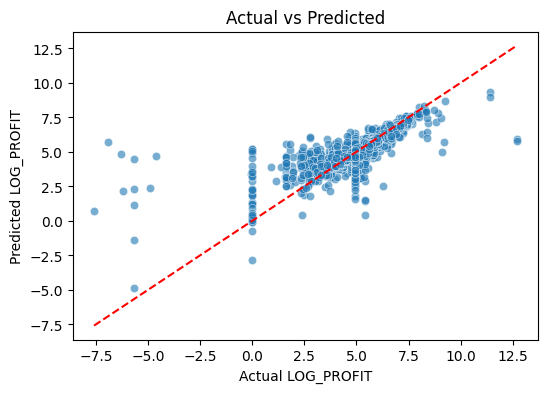

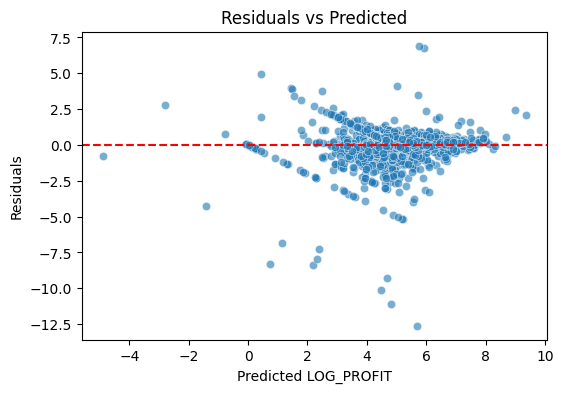

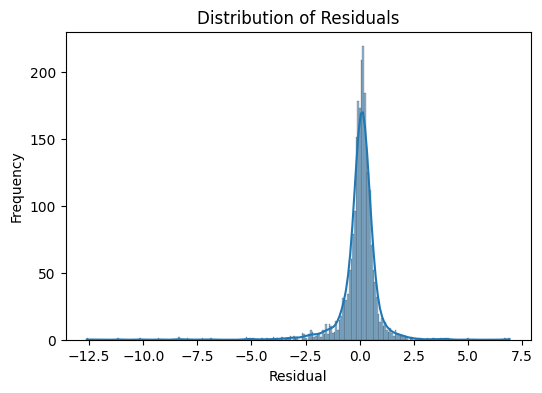

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred=grid_xgb.predict(X_test_encoded)


# Assuming: y_test, y_pred (e.g., from XGBoost best model)
residuals = y_test - y_pred

# 1. Actual vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual LOG_PROFIT")
plt.ylabel("Predicted LOG_PROFIT")
plt.title("Actual vs Predicted")
plt.show()

# 2. Residuals vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted LOG_PROFIT")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# 3. Residual Histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


Between the actual and predicted outputs there is a linear relationship that confirms that this model is performing a good job of predicting oututs closer to the actual values.

The second plot has the  residuals appear randomly scattered around 0, with no clear pattern such as a curve or trend,that implies no major bias in the model and that it has  captured the underlying data structure very well.

And by the third plot this notion is confirmed as the most prediction errors are small and the errors are approximately normally distributed, which further supports a good model fit .

XGBoost model is a strong performer on this dataset.
There are no visible signs of systematic bias, non-linearity, or heteroscedasticity, indicating that further complexity or transformations may not be necessary — at least in this current form.

C:\Users\Admin\AppData\Local\Temp\ipykernel_26736\3620794437.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=r2_scores, y=models, palette=['green', 'gray', 'gray'])


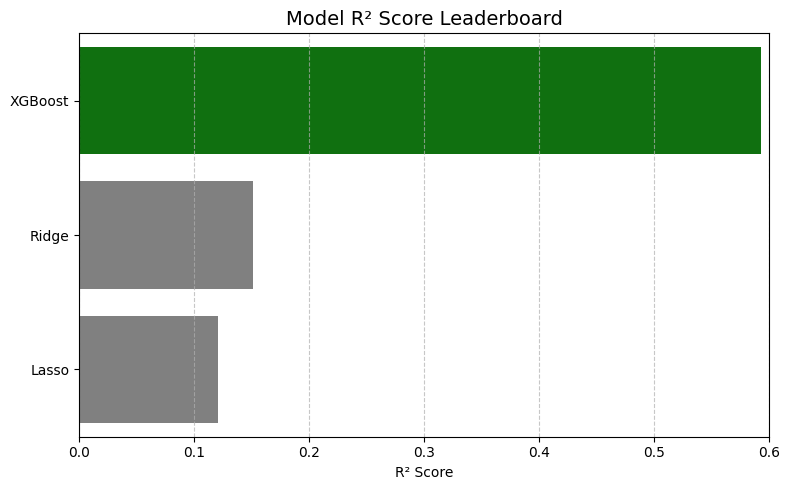

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ['XGBoost', 'Ridge', 'Lasso']
r2_scores = [0.5930, 0.1510, 0.1204]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=r2_scores, y=models, palette=['green', 'gray', 'gray'])

plt.title('Model R² Score Leaderboard', fontsize=14)
plt.xlabel('R² Score')
plt.xlim(0, 0.6)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


As visualised above among the three models used to fit on the dataset and perform prediction we see that xgboost has performed exceptionally well.It achieved the highest R² score . Additionally, it reported the lowest RMSE and MAE , confirming its superior accuracy and minimal prediction error compared to the linear models.

The R² score, while modest, is typical for real-world retail datasets. Retail sales are influenced by numerous unpredictable factors—such as sudden demand shifts, competitor pricing, and seasonal anomalies—which introduce natural noise into the data. These external and often unmeasured variables limit the maximum achievable predictive accuracy, even with advanced models.

**XGBoost Feature Importance Analysis**

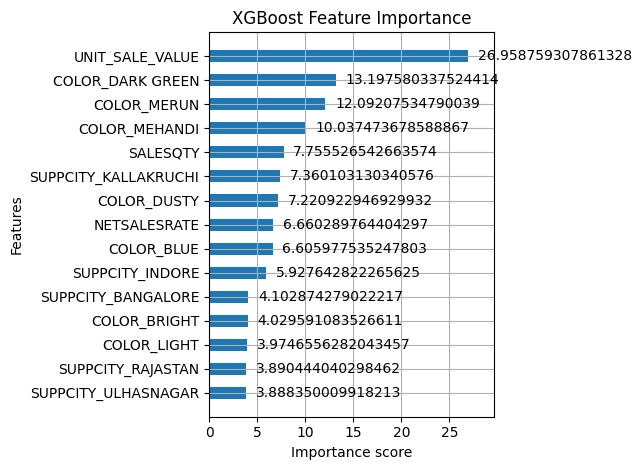

In [15]:
import matplotlib.pyplot as plt
import xgboost as xgb

booster = grid_xgb.best_estimator_.get_booster()
booster.feature_names = encoded_feature_names

xgb.plot_importance(
    booster,
    importance_type='gain',
    max_num_features=15,
    height=0.5,
    title='XGBoost Feature Importance'
)
plt.tight_layout()
plt.show()



From analyzing the importance of features in XGBoost prediction, we observe that the most important feature, Unit Sale Value, was also rightly identified by SHAP. Additionally, many of the top features identified by XGBoost are derived from categorical variables (e.g., COLOR_DARK GREEN, PATTERN_JUTE). These were likely encoded during preprocessing and indicate that specific product characteristics significantly influence profit.

**SUMMARY**


This project focused on profit prediction using real-time sales data from a textile shop (name withheld at the request of the owner)

1.**Data preprocessing**: I handled missing values and removed redundant features. Columns with excessive null values were dropped, while others were imputed appropriately.

2.**Exploratory data analysis (EDA)**:It allowed me to uncover trends and gain key insights into the data.

3.**Model training**: I used four regression models: Linear Regression, Lasso Regression, Ridge Regression, and XGBoost. Among these, XGBoost performed the best in terms of prediction accuracy.

4.**Hyperparameter tuning**:To further enhance model performance, I applied GridSearchCV to  identify the optimal configuration and improve model performance.

5.**SHAP analysis**:I used it to determine the most influential features based on their contribution to predictions. 

6.**Residual analysis**:Verified that model predictions were unbiased and errors were normally distributed.





**MY LEARNINGS**

Through this project, I expanded my hands-on experience beyond just training models:
* Improve model performance via GridSearchCV and feature selection.

* Interpret results using SHAP for model explainability.

* Validate predictions with residual analysis to assess model fit.


One challenge I encountered was the prolonged computational time of GridSearchCV, especially for models like XGBoost. In the future, I plan to explore more efficient hyperparameter tuning techniques like RandomizedSearchCV, Bayesian Optimization, or Optuna, to make the process faster and less computationally intensive.

